### New York
latitude = 40
<br>
longitude = -74

In [3]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas
from shapely.geometry import Point, LineString

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.0'

### NYC Transport Networks from OSM

In [2]:
G = ox.graph_from_place("New York, New York, USA", network_type="drive")
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

gdf_nodes = gdf_nodes.rename(columns = {'y':'latitude', 'x':'longitude'})

gdf_nodes.head()

,latitude,longitude,ref,highway,street_count,geometry
osmid,,,,,,
39076461,40.786409,-73.794627,33,motorway_junction,3,POINT (-73.79463 40.78641)
39076490,40.762429,-73.757091,31W,motorway_junction,3,POINT (-73.75709 40.76243)
39076504,40.753467,-73.744164,30W,motorway_junction,3,POINT (-73.74416 40.75347)
42421728,40.798048,-73.960044,NaN,traffic_signals,3,POINT (-73.96004 40.79805)
42421731,40.798645,-73.961474,NaN,traffic_signals,4,POINT (-73.96147 40.79865)


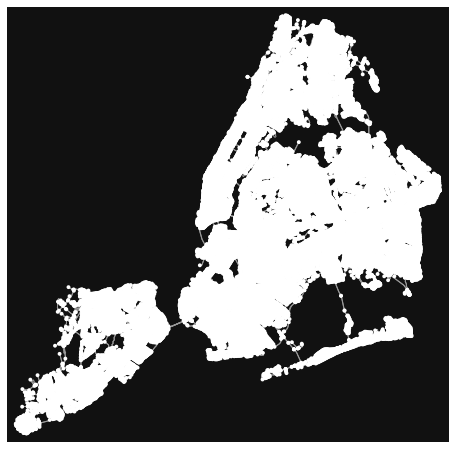

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
ox.plot.plot_graph(G)

In [ ]:
# Takes too much time to run. I still wanted to keep this code for future use.
"""G2 = ox.graph_from_place("New York, New York, USA", network_type="drive", retain_all = True, simplify =False)
gdf_nodes2, gdf_edges2 = ox.graph_to_gdfs(G)

gdf_nodes2 = gdf_nodes.rename(columns = {'y':'latitude', 'x':'longitude'})

gdf_nodes2.head()"""

### NYC Taxi Data

In [5]:
df_taxi = pd.read_csv('Sample NYC Data.csv')
df_taxi.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,01-01-13 15:11,01-01-13 15:18,4,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,06-01-13 0:18,06-01-13 0:22,1,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,05-01-13 18:49,05-01-13 18:54,1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,07-01-13 23:54,07-01-13 23:58,2,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,07-01-13 23:25,07-01-13 23:34,1,-73.976250,40.748528,-74.002586,40.747868


In [6]:
df_taxi = df_taxi[['medallion', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 
                   'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
df_taxi.head()

,medallion,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,01-01-13 15:11,01-01-13 15:18,4,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,06-01-13 0:18,06-01-13 0:22,1,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,05-01-13 18:49,05-01-13 18:54,1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,07-01-13 23:54,07-01-13 23:58,2,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,07-01-13 23:25,07-01-13 23:34,1,-73.976250,40.748528,-74.002586,40.747868


In [7]:
# Creating geopandas geometry arrays from coordinates. CRS value stands for coordinate reference system, I dunno much about it but looks like NYC 
# coordinates are correct. You can compare the values in our dataset with the ones in here, just visit New York in the map: 
# http://epsg.io/map#srs=4326&x=0.000000&y=0.000000&z=1&layer=streets

pickup_pt = geopandas.points_from_xy(df_taxi.pickup_longitude, df_taxi.pickup_latitude, crs = "EPSG:4326")
drop_pt = geopandas.points_from_xy(df_taxi.dropoff_longitude, df_taxi.dropoff_latitude, crs="EPSG:4326")

In [8]:
# Checking the number of closed loops, ie nodes that are connected to each other.

closed = (pickup_pt == drop_pt).sum()
tot = len(pickup_pt)
print(tot)
print(closed)
print('ratio:', round((closed / tot), 4))

99999
2935
ratio: 0.0294


In [9]:
# Turning the arrays into series
pickup_series = geopandas.GeoSeries(pickup_pt)
drop_series = geopandas.GeoSeries(drop_pt)

In [10]:
# Lets also transform the pandas dataframe into geopandas df. 
gdf = geopandas.GeoDataFrame(df_taxi)
gdf.head()

,medallion,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,01-01-13 15:11,01-01-13 15:18,4,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,06-01-13 0:18,06-01-13 0:22,1,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,05-01-13 18:49,05-01-13 18:54,1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,07-01-13 23:54,07-01-13 23:58,2,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,07-01-13 23:25,07-01-13 23:34,1,-73.976250,40.748528,-74.002586,40.747868


In [11]:
# After the node additions
gdf['pickup'] = pickup_series
gdf['dropoff'] = drop_series

gdf.head()

,medallion,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup,dropoff
0,89D227B655E5C82AECF13C3F540D4CF4,01-01-13 15:11,01-01-13 15:18,4,-73.978165,40.757977,-73.989838,40.751171,POINT (-73.97817 40.75798),POINT (-73.98984 40.75117)
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,06-01-13 0:18,06-01-13 0:22,1,-74.006683,40.731781,-73.994499,40.750660,POINT (-74.00668 40.73178),POINT (-73.99450 40.75066)
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,05-01-13 18:49,05-01-13 18:54,1,-74.004707,40.737770,-74.009834,40.726002,POINT (-74.00471 40.73777),POINT (-74.00983 40.72600)
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,07-01-13 23:54,07-01-13 23:58,2,-73.974602,40.759945,-73.984734,40.759388,POINT (-73.97460 40.75995),POINT (-73.98473 40.75939)
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,07-01-13 23:25,07-01-13 23:34,1,-73.976250,40.748528,-74.002586,40.747868,POINT (-73.97625 40.74853),POINT (-74.00259 40.74787)


In [12]:
# Sanity Checks
print('Number of unique pickup nodes:', gdf['pickup'].nunique())
print('Number of unique dropoff nodes:', gdf['dropoff'].nunique())
print('Total number of rows:', gdf.shape[0])

Number of unique pickup nodes: 95294
Number of unique dropoff nodes: 97267
Total number of rows: 99999


### Adding Lines

In [13]:
start = pickup_series[0]
end = drop_series[0]
print(start, end)

POINT (-73.978165 40.757977) POINT (-73.98983800000001 40.751171)


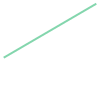

In [16]:
line = LineString([start, end])
line

In [17]:
line.bounds

(-73.989838, 40.751171, -73.978165, 40.757977)

In [18]:
list(line.coords)

[(-73.978165, 40.757977), (-73.989838, 40.751171)]

In [19]:
gdf['line'] = gdf.apply(lambda row: LineString([row['pickup'], row['dropoff']]), axis=1)
gdf.head()

,medallion,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup,dropoff,line
0,89D227B655E5C82AECF13C3F540D4CF4,01-01-13 15:11,01-01-13 15:18,4,-73.978165,40.757977,-73.989838,40.751171,POINT (-73.97817 40.75798),POINT (-73.98984 40.75117),"LINESTRING (-73.978165 40.757977, -73.98983800..."
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,06-01-13 0:18,06-01-13 0:22,1,-74.006683,40.731781,-73.994499,40.750660,POINT (-74.00668 40.73178),POINT (-73.99450 40.75066),"LINESTRING (-74.006683 40.731781, -73.994499 4..."
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,05-01-13 18:49,05-01-13 18:54,1,-74.004707,40.737770,-74.009834,40.726002,POINT (-74.00471 40.73777),POINT (-74.00983 40.72600),"LINESTRING (-74.004707 40.73777, -74.009834 40..."
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,07-01-13 23:54,07-01-13 23:58,2,-73.974602,40.759945,-73.984734,40.759388,POINT (-73.97460 40.75995),POINT (-73.98473 40.75939),"LINESTRING (-73.974602 40.759945, -73.984734 4..."
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,07-01-13 23:25,07-01-13 23:34,1,-73.976250,40.748528,-74.002586,40.747868,POINT (-73.97625 40.74853),POINT (-74.00259 40.74787),"LINESTRING (-73.97624999999999 40.748528, -74...."


### Another go at OSMnx 

The nearest nodes function takes longitude first, not latitude. Changing their order affected the outcome to the point that there were only 6 pickup nodes.

But even after changing the order, the function finds a small number of common nodes. This may be due to the imported osm graph, so we need to play with its parameters in order to increase the number of overlapping nodes.

In [64]:
gdf_test = gdf.copy()
gdf_test['pickup_osmnx'] = ox.distance.nearest_nodes(G, gdf['pickup_longitude'], gdf['pickup_latitude'], return_dist=False)
gdf_test['dropoff_osmnx'] = ox.distance.nearest_nodes(G, gdf['dropoff_longitude'], gdf['dropoff_latitude'], return_dist=False)


In [67]:
print('Number of unique pickup nodes:', gdf_test['pickup_osmnx'].nunique())
print('Number of unique dropoff nodes:', gdf_test['dropoff_osmnx'].nunique())
print('Total number of rows:', gdf.shape[0])

Number of unique pickup nodes: 4850
Number of unique dropoff nodes: 7713
Total number of rows: 99999


In [ ]:
"""gdf_test2 = gdf.copy()
gdf_test2['pickup_osmnx'] = ox.distance.nearest_nodes(G2, gdf['pickup_longitude'], gdf['pickup_latitude'], return_dist=False)
gdf_test2['dropoff_osmnx'] = ox.distance.nearest_nodes(G2, gdf['dropoff_longitude'], gdf['dropoff_latitude'], return_dist=False)"""

## Old

In [14]:
pickupdf['pickup_node'] = ox.distance.nearest_nodes(G, 
                                                    pickupdf['pickup_latitude'], pickupdf['pickup_longitude'], return_dist=False)

pickupdf.head()

<ipython-input-14-b7bf3e872253>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pickupdf['pickup_node'] = ox.distance.nearest_nodes(G,


,hack_license,pickup_datetime,passenger_count,pickup_latitude,pickup_longitude,pickup_node
0,BA96DE419E711691B9445D6A6307C170,01-01-13 15:11,4,40.757977,-73.978165,261367744
1,9FD8F69F0804BDB5549F40E9DA1BE472,06-01-13 0:18,1,40.731781,-74.006683,261367744
2,9FD8F69F0804BDB5549F40E9DA1BE472,05-01-13 18:49,1,40.737770,-74.004707,261367744
3,51EE87E3205C985EF8431D850C786310,07-01-13 23:54,2,40.759945,-73.974602,261367744
4,51EE87E3205C985EF8431D850C786310,07-01-13 23:25,1,40.748528,-73.976250,261367744


In [15]:
print(pickupdf.nunique())

hack_license         9990
pickup_datetime      1632
passenger_count         7
pickup_latitude     25976
pickup_longitude    13045
pickup_node             6
dtype: int64


### Try using the function I created on just a list; this list was created from the NYC taxi dataset (called pickupdf in this notebook)

In [16]:
lats = pickupdf['pickup_latitude'].tolist()
longs = pickupdf['pickup_longitude'].tolist()

In [17]:
def latlongtonode(latitude, longitude):
    return ox.distance.nearest_nodes(G, latitude, longitude, return_dist=False)

In [18]:
nodeids = latlongtonode(lats, longs)

Count the number of unique nodes as a result of running the function I created

In [19]:
nodeset = set(nodeids)
print(nodeset)

{261367744, 42850178, 42956520, 42850190, 1344102799, 43018687}


# Result: only six unique nodes from the function Geoff Boeing suggested using:

https://stackoverflow.com/questions/67441339/how-to-map-latitudes-longitudes-to-nodes

Am I using this function incorrectly? Why are there only six matching nodes from our taxi dataset containing 100,000 (actually, 99,999) records?